# UV-Vis Analysis

UV-Vis measurements were performed to extract an accurate conjugated polymer concentration in all blend samples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy import stats

In [2]:
# defining convenient colors and names for plotting

cal_colors = {
    1: 'goldenrod',
    2: 'darkorange',
    3: 'firebrick',
    4: 'forestgreen',
    5: 'darkcyan',
    6: 'dodgerblue',
    7: 'mediumblue',
    8: 'darkorchid',
    9: 'deeppink'
}

cal_names = {
    1: 'RRe-P3HT & dPS at 0.02 mg/mL',
    2: 'RRe-P3HT & dPS at 0.1 mg/mL',
    3: 'RRe-P3HT & dPS at 1 mg/mL',
    4: 'RRa-P3HT & dPS at 0.1 mg/mL',
    5: 'RRa-P3HT & dPS at 1 mg/mL',
    6: 'P3DDT & dPS at 0.1 mg/mL',
    7: 'P3DDT & dPS at 1 mg/mL',
    8: 'PQT-12 & dPS at 0.1 mg/mL',
    9: 'PQT-12 & dPS at 1 mg/mL'
}

### Loading UV-Vis data and meta-data

In [3]:
# Loading raw UV-Vis data
data_dir = '../data/uv_vis/uv_vis_data/'
uvvis_files = [data_dir + x for x in os.listdir(data_dir) if 'txt' in x]

uvvis_data = {}

for filename in uvvis_files:
    
    key = filename.split('/')[-1][:-4]
    
    data = np.loadtxt(filename, skiprows=4, dtype = str)
    if np.size(data,1) > 2:
        key = filename.split('/')[-1][:-4]
        file = open(filename, 'r')
        for i in range(3):
            line = file.readline().split('\t')
        file.close()
        ind = [i for i,label in enumerate(line) if key in label][0]
        data = data[:,ind:ind+2]
    data = data[np.where(data[:,1] != 'XXX.XXX')].astype(float)

    uvvis_data[key] = data

In [4]:
# sample meta-data
sample_info = pd.read_csv('../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight fraction of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']))


In [5]:
# matching UV-Vis sample keys (e.g. UV-403-0p1-1) to solid blend sample keys (e.g. 403)
# in helpful dictionaries for later analysis

uv2key = {}
key2uv = {}

for key in target.keys():
    key2uv[key] = [] # initialize dictionary with empty list for key replicates

for uv in [uv for uv in uvvis_data.keys() if uv[:3]=='UV-']:
    key = int(uv.split('-')[1])
    key2uv[key].append(uv)
    uv2key[uv] = key

### Peak Fitting

All UV-Vis data, from both samples and calibration curves, will undergo a fitting process to extract the conjugated polymer peak height (absorbance) and location (wavelength) which can be related to the concentration of conjugated polymer. A full description of the UV-Vis experiment process can be found in the supplemental information.

In [6]:
def peak_analysis(data, min_nm=None, max_nm=None, width=30, set_nm=None):
    
    """
    Finds the peak location and absorbance for UV-Vis data.
    
    The function will assume that the data is trimmed so that the peak
    of interest is the highest point in the data to fit. Use 
    parameters 'min_nm' and 'max_nm' to trim the data accordingly.
    
    Parameters
    ----------
    data : ndarray
        UV-Vis data to be fit.
        First index along axis=1 wavelength in nm.
        Second index along axis=1 absorbance intensity.
    min_nm : int, float
        Minimum wavelength to trim the data for fitting.
        Function assumes peak is highest point in the data.
        Defult: None
    max_nm : int, float
        Maximum wavelength to trim the data upon loading.
        Function assumes peak is highest point in the data.
        Default: None
    width : int, float
        Specifies one half the full range of data (in nanometers)
        to be used for peak fitting. 
        Example: The peak (initial guess) is found at the highest
        absorbance at 430 nm. If width is set to 30 nm, the data
        between 400 and 460 nm will be fit.
        Default: 30 nm
    set_nm : float
        Can be used to define the initial guess of peak position,
        rather than using the maximum absorbance in the range
        specified. This could be useful if the peak is 
        very low or the data cannot easily be trimmed.
        Default: None
    
    Returns
    -------
    peak_nm : float
        Location of the peak in nm.
    peak_abs : float
        Absorbance value at the peak location.
    p : numpy.poly1d
        2nd-degree polynomial fit of the peak position.
        
    """
    
    # trimming the data
    if min_nm is not None:
        data = data[np.where(data[:,0] >= min_nm)]
    if max_nm is not None:
        data = data[np.where(data[:,0] <= max_nm)]
    
    # defining the peak position (or initial guess)
    if set_nm is None:
        peak0 = data[np.where(data[:,1] == np.max(data[:,1]))][0][0]
    else:
        peak0 = set_nm
    
    # setting the fitting range in nanometers
    min_fit = peak0 - width
    max_fit = peak0 + width
    
    mask = np.where((data[:,0] > min_fit) & (data[:,0] < max_fit))
    fit_data = data[mask]
    
    # fitting a 2nd degree polynomial
    fit = np.polyfit(fit_data[:,0], fit_data[:,1], 2)
    p = np.poly1d(fit)
    
    # first derivative to easily find peak location
    p1 = p.deriv()
    peak_nm = p1.r[0]
    
    if set_nm is not None:
        peak_nm = set_nm
    
    # using peak location to find the fit absorbance at the peak
    peak_abs = p(peak_nm)
    
    return (peak_nm, peak_abs, p)

In [7]:
peak_fits = {} # key is UV-Vis sample id, value is (peak_nm, peak_abs, peak_fit) or results of peak_analysis function

for uv, data in uvvis_data.items():
    if 'UV' in uv:
        if target[uv2key[uv]] > 0.001:
            peak_fits[uv] = peak_analysis(data, min_nm=325, max_nm=600)
    else:
        peak_fits[uv] = peak_analysis(data, min_nm=325, max_nm=600)

# for low concentration samples the peak is difficult to find
# will use the set_nm argument of `peak_analysis` and will set
# it to the average of peak locations for the next sample in the
# series at the next highest concentration
# example: reference sample 7 for sample 6

for uv, data in uvvis_data.items():
    if uv not in peak_fits.keys():
        key = uv2key[uv]
        ref_key = key + 1
        ref_peaks = []
        for ref_uv in key2uv[ref_key]:
            ref_peaks.append(peak_fits[ref_uv][0])
        set_nm = round(np.average(ref_peaks),0)
        peak_fits[uv] = peak_analysis(data, min_nm=325, max_nm=600, set_nm=set_nm)
        

### Calibration Curves

Loading calibration curve information matching calibration curve sample to actual conjugated polymer weight percent.

In [8]:
cal_wts = {}

cal_info = []
for file in ['../data/uv_vis/Cal_Curve_wtPercents/'+file for file in os.listdir('../data/uv_vis/Cal_Curve_wtPercents') if 'Cal' in file]:
    cal_info.append(np.loadtxt(file, skiprows=1, delimiter=',', dtype=str))

cal_info = np.vstack(cal_info)
for key, percent in cal_info:
    cal_wts[key] = float(percent)

We will plot both the peak location and the peak fits for all the calibration samples to ensure that peak analysis is performed correclty.

In [9]:
def plot_cal_peak_nm(curve_no, peak_fits, cal_wts, cal_names, cal_colors):
    
    """
    Will plot the calibration curve peak locations
    as a function of conjugated polymer concentration.
    """
    
    plt.figure(figsize=(6,6))
    
    # filter which data to plot
    uvs = [uv for uv in peak_fits.keys() if uv[:4]=='Cal' + str(curve_no)]

    for uv in uvs:
        peak_nm, peak_abs, peak_fit = peak_fits[uv]
        if uv in cal_wts.keys():
            wt = cal_wts[uv]
            plt.scatter([wt],[peak_nm], color=cal_colors[curve_no])
        
    plt.title('Calibration Curve '+ str(curve_no) + ': ' + cal_names[curve_no], fontsize=16)
    plt.ylabel('Peak Location (nm)', fontsize=16)
    plt.xlabel('CP Weight%', fontsize=16)
    
    plt.show()
    plt.close()

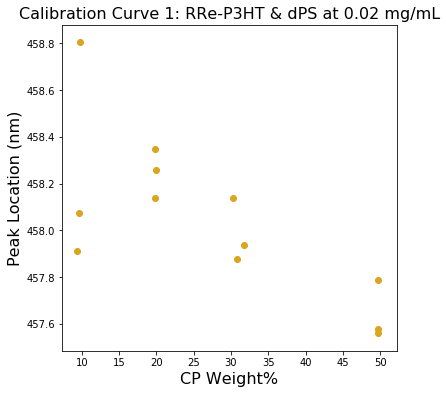

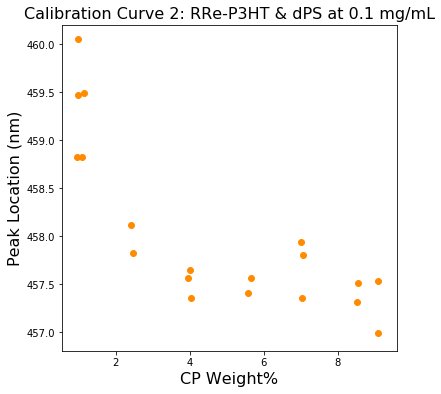

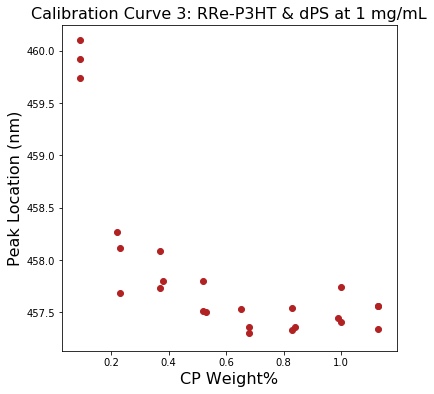

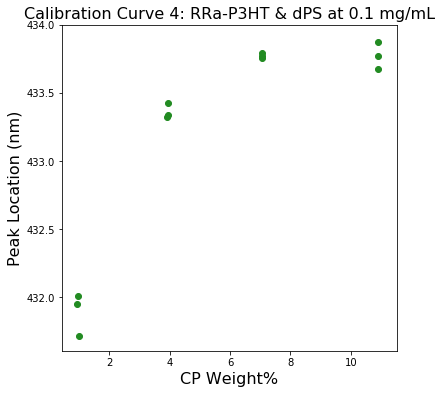

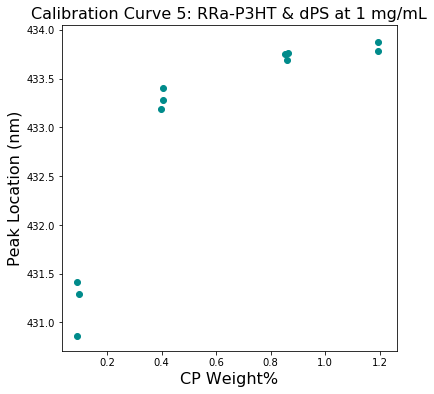

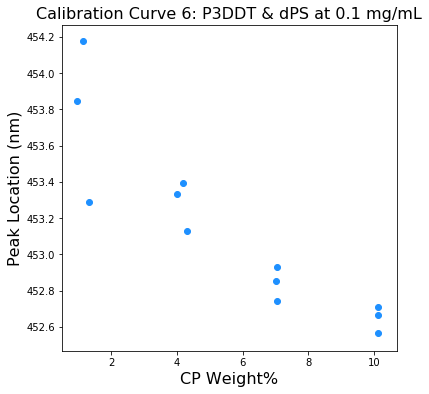

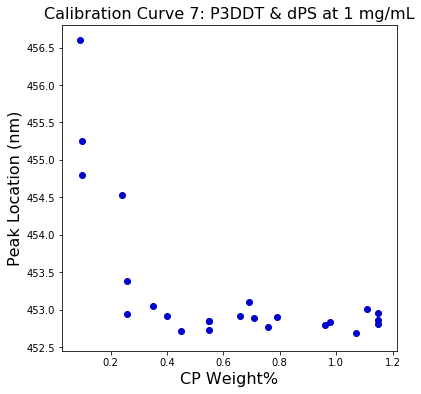

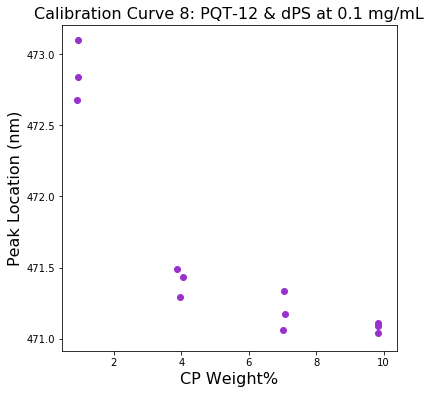

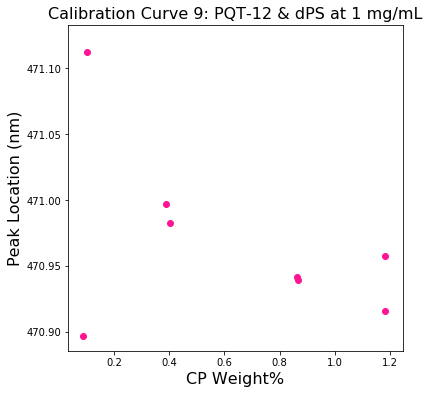

In [10]:
plot_cal_peak_nm(1, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(2, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(3, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(4, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(5, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(6, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(7, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(8, peak_fits, cal_wts, cal_names, cal_colors)
plot_cal_peak_nm(9, peak_fits, cal_wts, cal_names, cal_colors)

In [11]:
def plot_peak_fit(data, peak_nm, fit, color, width=30):
    
    """
    Plots UV-Vis data and the corresponding peak fit.
    
    Parameters
    ----------
    data : ndarray
        UV-Vis data to be plotted.
        First index along axis=1 wavelength in nm.
        Second index along axis=1 absorbance intensity.
    peak_nm : float
        Location of the peak in nm.
    fit : numpy.poly1d
        Fit of the peak location.
    color : matplotlib color
    width : int
        Defines half the range (in nanometers) centered
        at the peak position to plot of the fit.
        
    """
    
    plt.plot(data[:,0], data[:,1], c=color, linewidth=1)
    x = np.arange(peak_nm-30, peak_nm+30)
    plt.plot(x, fit(x), c=color,  linewidth=6)
    
    

In [12]:
def plot_cal_curves(curve_no, peak_fits, uvvis_data, cal_names):
    
    # filter which data to plot
    uvs = [uv for uv in peak_fits.keys() if uv[:4]=='Cal' + str(curve_no)]
    
    # setting up colors to show peak fits with uv-vis data
    color_map = cm.get_cmap('gist_rainbow', len(uvs))
    color_list = [color_map(i) for i in np.arange(0,len(uvs))]
    for uv, color in zip(uvs,color_list):
        data = uvvis_data[uv]
        peak_nm, peak_abs, peak_fit = peak_fits[uv]
        plot_peak_fit(data, peak_nm, peak_fit, np.array(color))

    plt.title('Calibration Curve '+ str(curve_no) + ': ' + cal_names[curve_no], fontsize=16)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.ylabel('Absorbance', fontsize=16)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(350,600)
    plt.ylim(0,1.0)

    plt.show()
    plt.close()

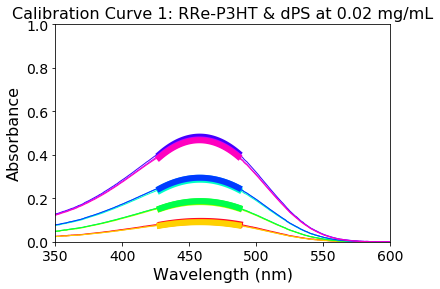

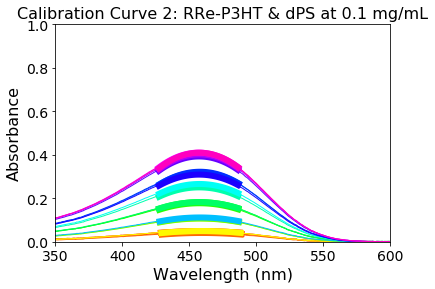

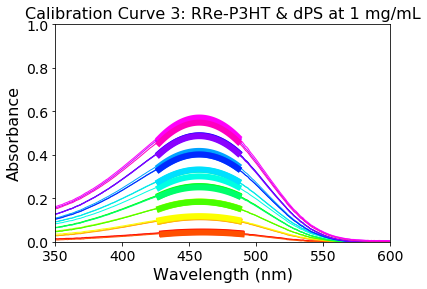

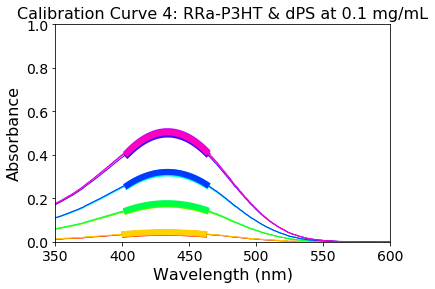

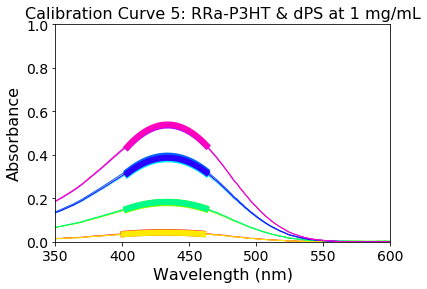

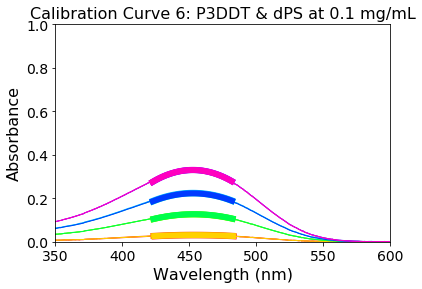

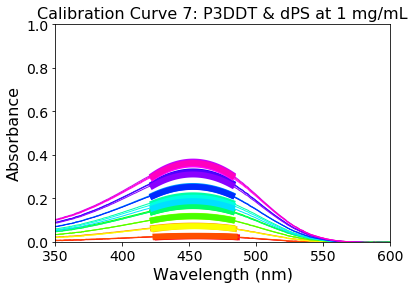

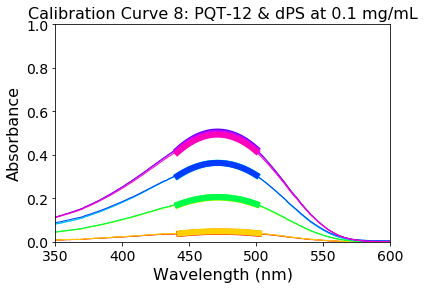

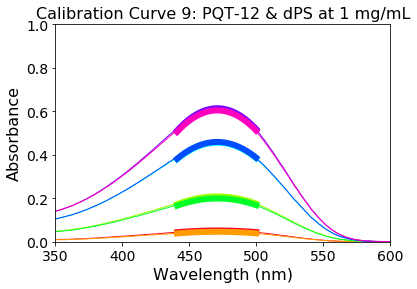

In [13]:
plot_cal_curves(1, peak_fits, uvvis_data, cal_names)
plot_cal_curves(2, peak_fits, uvvis_data, cal_names)
plot_cal_curves(3, peak_fits, uvvis_data, cal_names)
plot_cal_curves(4, peak_fits, uvvis_data, cal_names)
plot_cal_curves(5, peak_fits, uvvis_data, cal_names)
plot_cal_curves(6, peak_fits, uvvis_data, cal_names)
plot_cal_curves(7, peak_fits, uvvis_data, cal_names)
plot_cal_curves(8, peak_fits, uvvis_data, cal_names)
plot_cal_curves(9, peak_fits, uvvis_data, cal_names)

We need to perform a linear fit to the calibration curve data of peak absorbance versus conjugated polymer weight percent. This will be used to correct the sample uv-vis data and compare the target conjugated polymer concentration to the actual concentration.

In [14]:
def fit_calibration(curve_no, peak_fits, cal_wts, cal_colors, cal_names, cal_fits):
    
    """
    Will peform linear fit of peak absorbance versus conjugated
    polymer weight percent for the specified calibration curve.
    
    The slope will get saved to the 'cal_fits' dictionary supplied
    as the last argument. This will enable correction of later
    samples in the future.
    
    """
    
    points = []

    for uv in [uv for uv in peak_fits.keys() if uv[:4] == 'Cal' + str(curve_no)]:
        if uv in cal_wts.keys():
            points.append(cal_wts[uv])
            points.append(peak_fits[uv][1])
    points =  np.array(points).reshape((-1,2))

    plt.figure(figsize=(6,6))

    plt.scatter(points[:,0], points[:,1], c=cal_colors[curve_no], s=60)

    slope, residuals, rank, s = np.linalg.lstsq(points[:,0].reshape(1,-1).T,points[:,1], rcond=None)
    slope = slope[0]
    x = np.linspace(0, max(points[:,0]),100)
    y = slope*x
    plt.plot(x, y, c='black')
    cal_fits[curve_no] = slope

    plt.xlabel(cal_names[curve_no].split()[0]+' wt%', fontsize=16)
    plt.xticks(fontsize=14)

    plt.ylabel('Peak Absorbance', fontsize=16)
    plt.yticks(fontsize=14)

    plt.title('Calibration Curve ' + str(curve_no) + ':\n' + cal_names[curve_no], fontsize=16)

    x = np.min(points[:,0])
    y = np.max(points[:,1])
    dy = np.max(points[:,1]) - np.min(points[:,1])

    #plt.text(x, y - 0.02*dy,'R-squared: ' + str(np.round(r_value**2,4)), fontsize=12)
    plt.text(0, y - 0.05*dy,'Slope: ' + str(np.round(slope,4)), fontsize=14)

    plt.tight_layout()
    plt.savefig('../data/uv_vis/calibration_figures/Cal' + str(curve_no) + '.png', res=500)
    
    return cal_fits

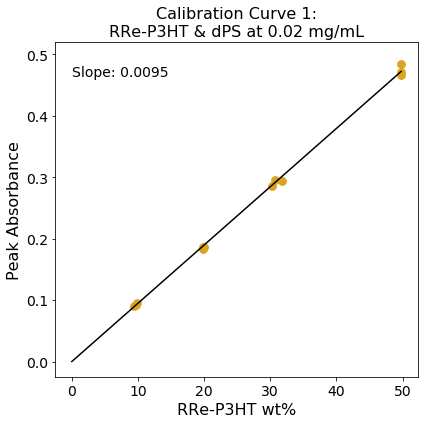

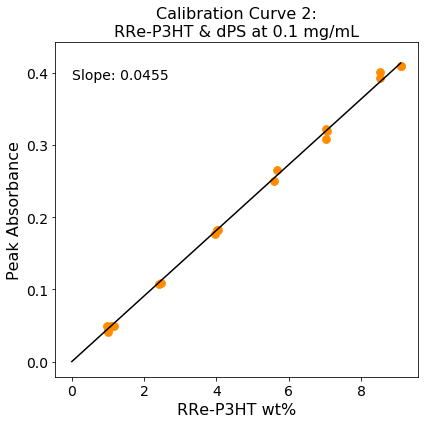

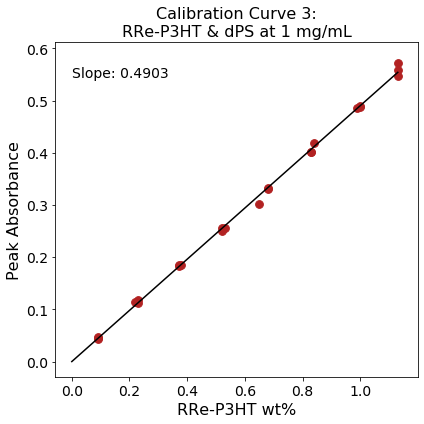

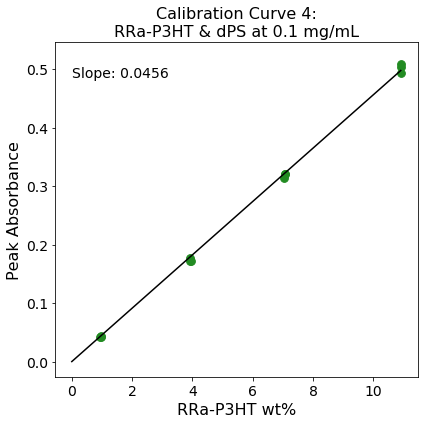

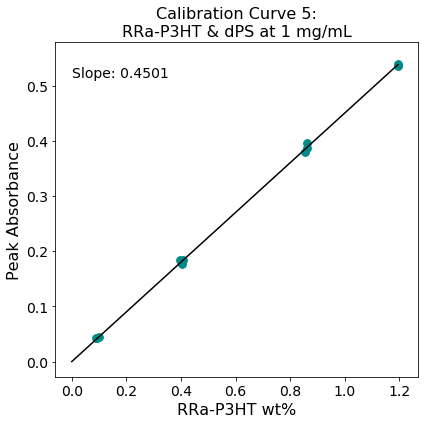

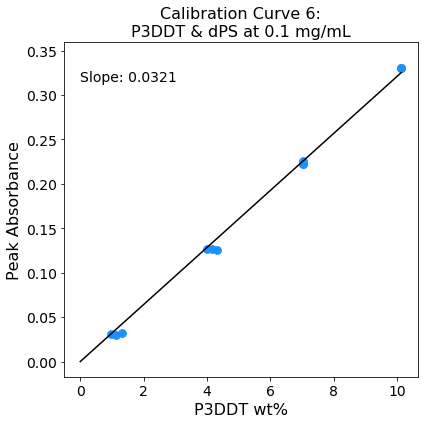

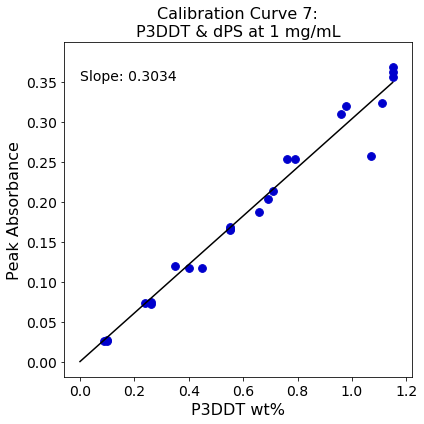

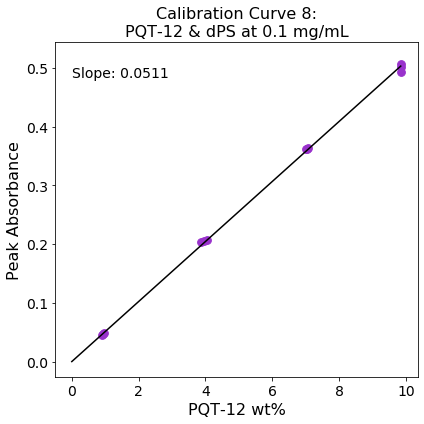

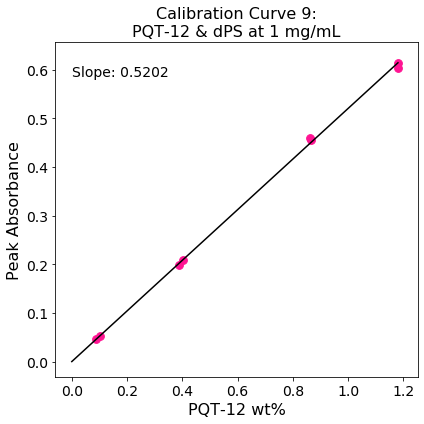

In [15]:
cal_fits = {} # key is calibration curve number, value is slope
os.makedirs('../data/uv_vis/calibration_figures', exist_ok=True)

cal_fits = fit_calibration(1, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(2, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(3, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(4, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(5, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(6, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(7, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(8, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)
cal_fits = fit_calibration(9, peak_fits, cal_wts, cal_colors, cal_names, cal_fits)

### Samples

In [16]:
# Assigning samples to calibration curves
cal_info = np.loadtxt('../data/uv_vis/CalCurveAssign.csv', skiprows=1, delimiter=',', dtype=str)
cal_assign = {}
for key, cal in cal_info:
    cal_assign[key] = int(cal)

Plotting the UV-Vis data with and without peak fits.

In [17]:
def plot_uvvis_data(keys, cp, solvent, cal_assign, replicate=None, slowdry=False): 

    plt.figure(figsize=(6,4))
    
    colors = {
        0.001: 'firebrick',
        0.005: 'darkorange',
        0.01: 'darkcyan',
        0.05: 'darkgreen',
        0.1: 'darkblue',
        0.25: 'darkorchid',
        0.5: 'deeppink'
    }
    
    cal_concentrations = {
        1: '0.02 mg/mL',
        2: '0.1 mg/mL',
        3: '1 mg/mL',
        4: '0.1 mg/mL',
        5: '1 mg/mL',
        6: '0.1 mg/mL',
        7: '1 mg/mL',
        8: '0.1 mg/mL',
        9: '1 mg/mL',
    }
    
    uvs = []
    color_map = []
    for key in keys:
        plt.plot([-100,-200],[-1,-2],color=colors[target[key]], label = str(round(target[key]*100,1)) + ' wt% ' + cp + ' at ' + cal_concentrations[cal_assign[key2uv[key][0]]])
        uvs.extend(key2uv[key])
        num = len(key2uv[key])
        color_map.extend([colors[target[key]]]*num)
    
    for uv, color in zip(uvs,color_map):
        data = uvvis_data[uv]
        peak_nm, peak_abs, peak_fit = peak_fits[uv]
        plt.plot(data[:,0], data[:,1], color=color, label=None)
    
    plt.legend()

    title = cp + ' & dPS from ' + solvent
    filename = cp + '_dPS_' + solvent + '_UVVis.png'

    if slowdry is True:
        title += ' (SLOW DRY)'
        filename = cp + '_dPS_' + solvent + '_SLOWDRY_UVVis.png'
    if replicate is not None:
        title += ' - Replicate ' + str(replicate)
        filename = cp + '_dPS_' + solvent + '_UVVis_' + str(replicate) + '.png'

    plt.title(title, fontsize=16)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.ylabel('Absorbance', fontsize=16)

    plt.xlim(300,550)
    plt.ylim(0,0.6)
                 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.tight_layout()

    plt.savefig('../data/uv_vis/sample_figures/' + filename, dpi=100)


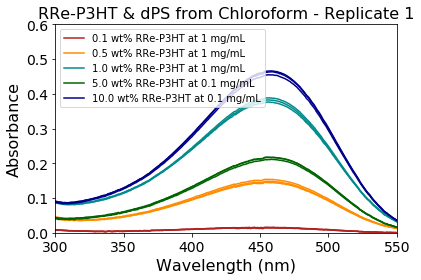

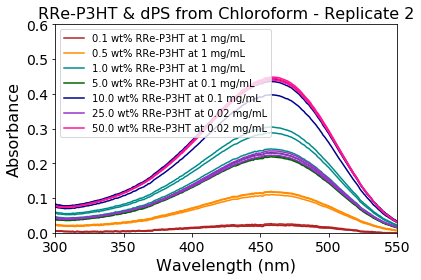

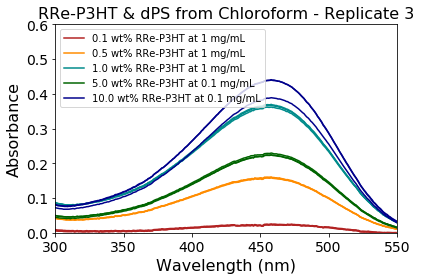

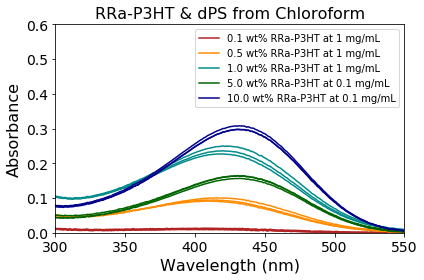

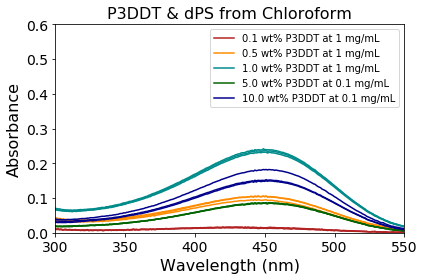

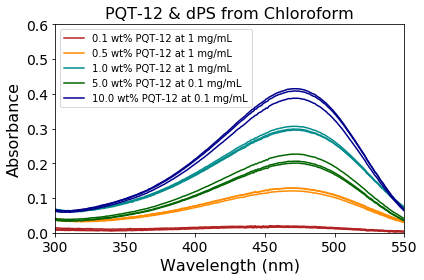

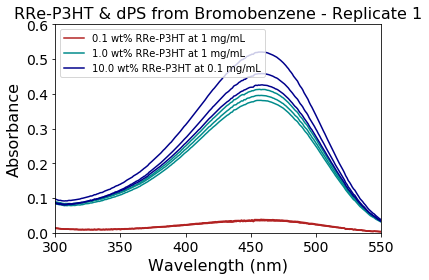

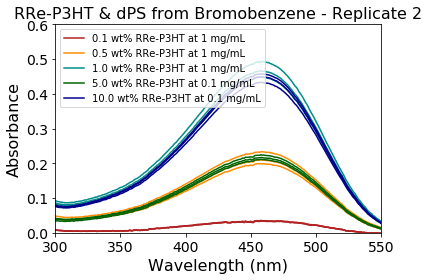

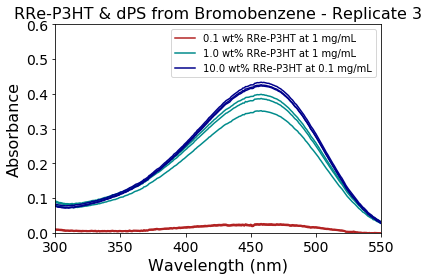

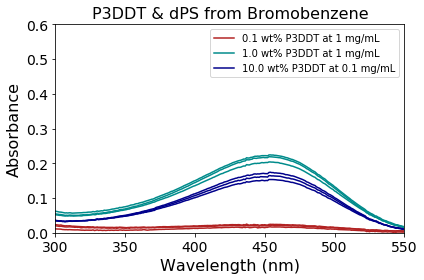

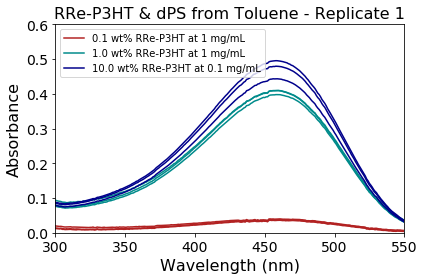

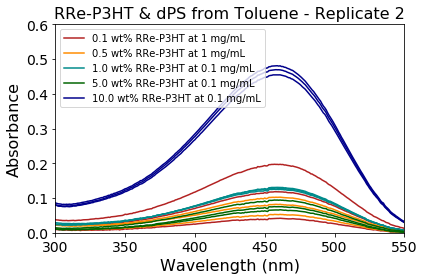

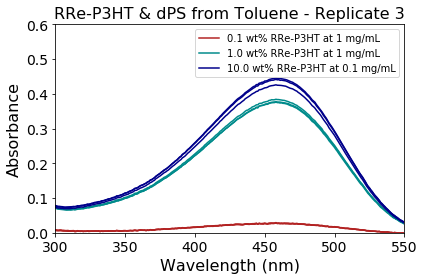

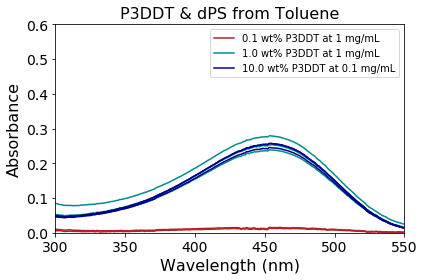

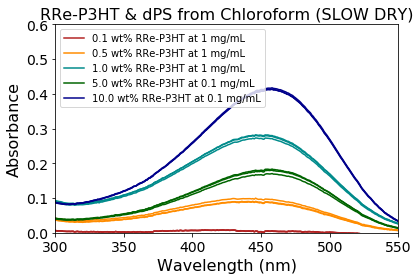

In [18]:
plot_uvvis_data([1,2,3,4,5], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=1, slowdry=False)
plot_uvvis_data([101,102,103,104,105,106,107], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=2, slowdry=False)
plot_uvvis_data([108,109,110,111,112], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=3, slowdry=False)

plot_uvvis_data([6,7,8,9,10], 'RRa-P3HT', 'Chloroform', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data([11,12,13,14,15], 'P3DDT', 'Chloroform', cal_assign, replicate=None, slowdry=False)
plot_uvvis_data([16,17,18,19,20], 'PQT-12', 'Chloroform', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data([22,23,24], 'RRe-P3HT', 'Bromobenzene', cal_assign, replicate=1, slowdry=False)
plot_uvvis_data([301,302,303,304,305], 'RRe-P3HT', 'Bromobenzene', cal_assign, replicate=2, slowdry=False)
plot_uvvis_data([306,307,308], 'RRe-P3HT', 'Bromobenzene', cal_assign, replicate=3, slowdry=False)
plot_uvvis_data([25,26,27], 'P3DDT', 'Bromobenzene', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data([29,30,31], 'RRe-P3HT', 'Toluene', cal_assign, replicate=1, slowdry=False)
plot_uvvis_data([401,402,403,404,405], 'RRe-P3HT', 'Toluene', cal_assign, replicate=2, slowdry=False)
plot_uvvis_data([406,407,408], 'RRe-P3HT', 'Toluene', cal_assign, replicate=3, slowdry=False)
plot_uvvis_data([32,33,34], 'P3DDT', 'Toluene', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data([501,502,503,504,505], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=None, slowdry=True)

In [19]:
../data/uv_vis/def plot_uvvis_data_fits(keys, cp, solvent, cal_assign, replicate=None, slowdry=False): 

    plt.figure(figsize=(6,4))
    
    colors = {
        0.001: 'firebrick',
        0.005: 'darkorange',
        0.01: 'darkcyan',
        0.05: 'darkgreen',
        0.1: 'darkblue',
        0.25: 'darkorchid',
        0.5: 'deeppink'
    }
    
    cal_concentrations = {
        1: '0.02 mg/mL',
        2: '0.1 mg/mL',
        3: '1 mg/mL',
        4: '0.1 mg/mL',
        5: '1 mg/mL',
        6: '0.1 mg/mL',
        7: '1 mg/mL',
        8: '0.1 mg/mL',
        9: '1 mg/mL',
    }
    
    uvs = []
    color_map = []
    for key in keys:
        plt.plot([-100,-200],[-1,-2],color=colors[target[key]], label = str(round(target[key]*100,1)) + ' wt% ' + cp + ' at ' + cal_concentrations[cal_assign[key2uv[key][0]]])
        uvs.extend(key2uv[key])
        num = len(key2uv[key])
        color_map.extend([colors[target[key]]]*num)
    
    for uv, color in zip(uvs,color_map):
        data = uvvis_data[uv]
        peak_nm, peak_abs, peak_fit = peak_fits[uv]
        plot_peak_fit(data, peak_nm, peak_fit, color)
    
    plt.legend()

    title = cp + ' & dPS from ' + solvent
    filename = cp + '_dPS_' + solvent + '_UVVis_Peak_Fit.png'

    if slowdry is True:
        title += ' (SLOW DRY)'
        filename = cp + '_dPS_' + solvent + '_UVVis_Peak_Fit_SLOWDRY_UVVis.png'
    if replicate is not None:
        title += ' - Replicate ' + str(replicate)
        filename = cp + '_dPS_' + solvent + '_UVVis_Peak_Fit_' + str(replicate) + '.png'

    plt.title(title, fontsize=16)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.ylabel('Absorbance', fontsize=16)

    plt.xlim(300,550)
    plt.ylim(0,0.6)
                 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.tight_layout()

    plt.savefig('../data/uv_vis/sample_figures/' + filename, dpi=100)


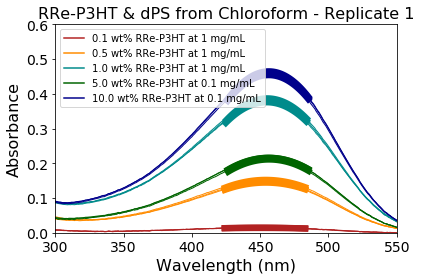

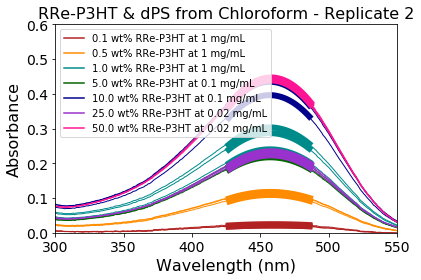

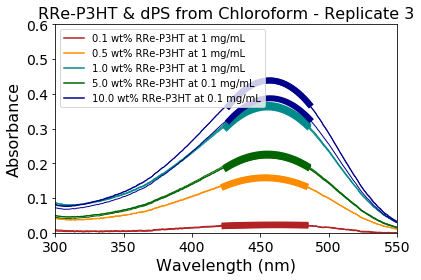

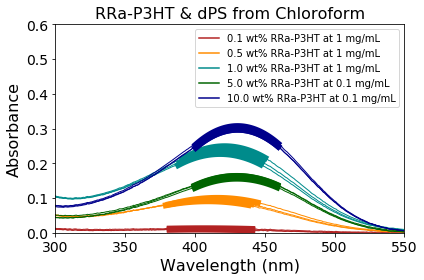

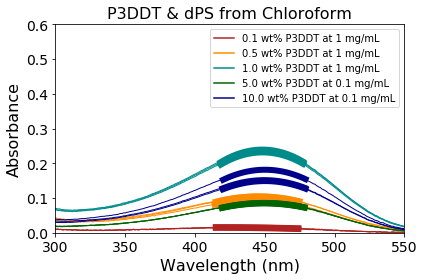

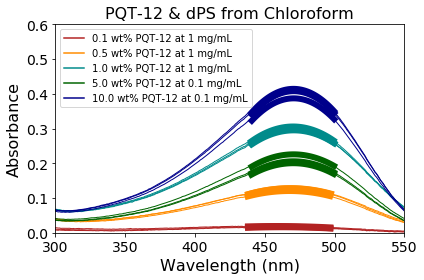

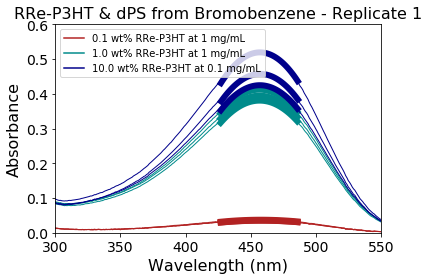

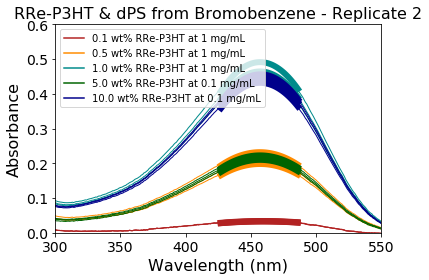

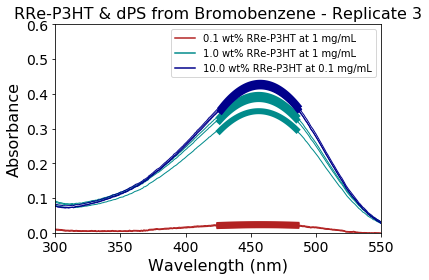

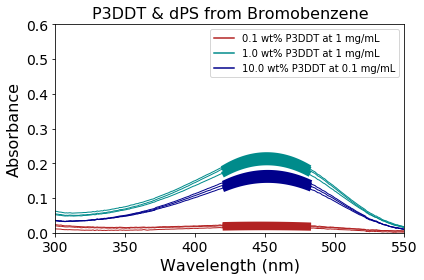

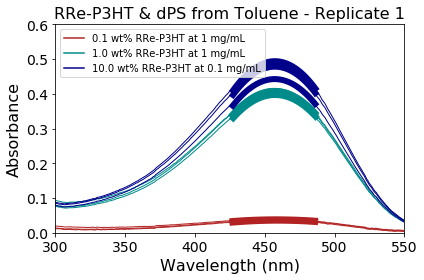

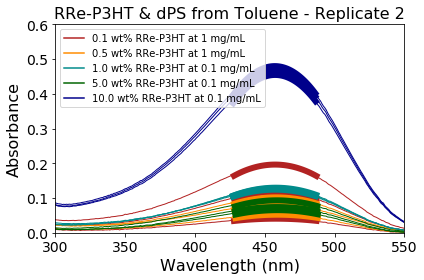

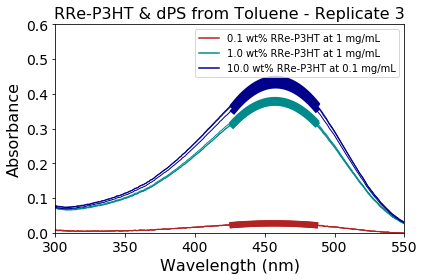

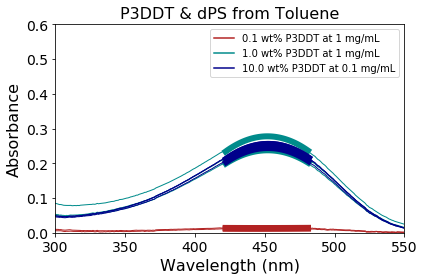

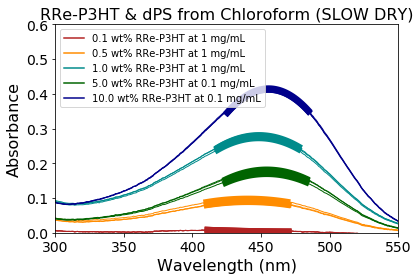

In [20]:
plot_uvvis_data_fits([1,2,3,4,5], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=1, slowdry=False)
plot_uvvis_data_fits([101,102,103,104,105,106,107], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=2, slowdry=False)
plot_uvvis_data_fits([108,109,110,111,112], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=3, slowdry=False)

plot_uvvis_data_fits([6,7,8,9,10], 'RRa-P3HT', 'Chloroform', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data_fits([11,12,13,14,15], 'P3DDT', 'Chloroform', cal_assign, replicate=None, slowdry=False)
plot_uvvis_data_fits([16,17,18,19,20], 'PQT-12', 'Chloroform', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data_fits([22,23,24], 'RRe-P3HT', 'Bromobenzene', cal_assign, replicate=1, slowdry=False)
plot_uvvis_data_fits([301,302,303,304,305], 'RRe-P3HT', 'Bromobenzene', cal_assign, replicate=2, slowdry=False)
plot_uvvis_data_fits([306,307,308], 'RRe-P3HT', 'Bromobenzene', cal_assign, replicate=3, slowdry=False)
plot_uvvis_data_fits([25,26,27], 'P3DDT', 'Bromobenzene', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data_fits([29,30,31], 'RRe-P3HT', 'Toluene', cal_assign, replicate=1, slowdry=False)
plot_uvvis_data_fits([401,402,403,404,405], 'RRe-P3HT', 'Toluene', cal_assign, replicate=2, slowdry=False)
plot_uvvis_data_fits([406,407,408], 'RRe-P3HT', 'Toluene', cal_assign, replicate=3, slowdry=False)
plot_uvvis_data_fits([32,33,34], 'P3DDT', 'Toluene', cal_assign, replicate=None, slowdry=False)

plot_uvvis_data_fits([501,502,503,504,505], 'RRe-P3HT', 'Chloroform', cal_assign, replicate=None, slowdry=True)

Plotting peak locations.

Text(0.5, 0, 'Sample Number')

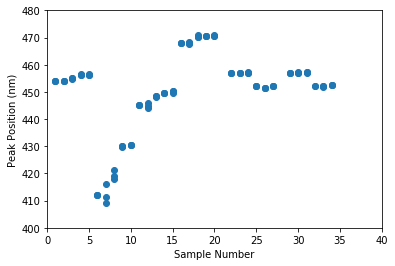

In [21]:
keys = []
peak_nm = []
for (key, uvs) in key2uv.items():
    for uv in uvs:
        keys.append(key)
        peak_nm.append(peak_fits[uv][0])
        
plt.scatter(keys, peak_nm)
plt.xlim(0,40)
plt.ylim(400,480)
plt.ylabel('Peak Position (nm)')
plt.xlabel('Sample Number')

Text(0.5, 0, 'Sample Number')

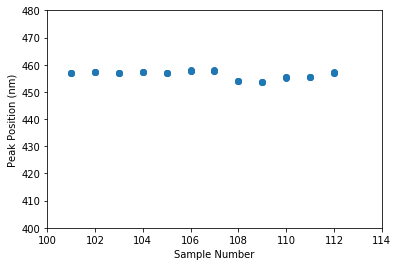

In [22]:
keys = []
peak_nm = []
for (key, uvs) in key2uv.items():
    for uv in uvs:
        keys.append(key)
        peak_nm.append(peak_fits[uv][0])
        
plt.scatter(keys, peak_nm)
plt.xlim(100,114)
plt.ylim(400,480)
plt.ylabel('Peak Position (nm)')
plt.xlabel('Sample Number')

Text(0.5, 0, 'Sample Number')

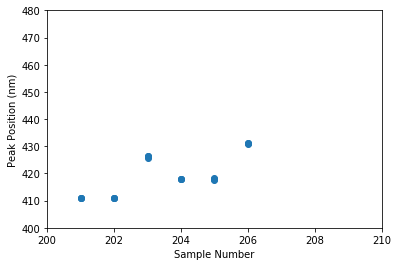

In [23]:
keys = []
peak_nm = []
for (key, uvs) in key2uv.items():
    for uv in uvs:
        keys.append(key)
        peak_nm.append(peak_fits[uv][0])
        
plt.scatter(keys, peak_nm)
plt.xlim(200,210)
plt.ylim(400,480)
plt.ylabel('Peak Position (nm)')
plt.xlabel('Sample Number')

Text(0.5, 0, 'Sample Number')

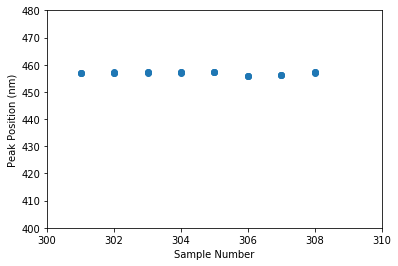

In [24]:
keys = []
peak_nm = []
for (key, uvs) in key2uv.items():
    for uv in uvs:
        keys.append(key)
        peak_nm.append(peak_fits[uv][0])
        
plt.scatter(keys, peak_nm)
plt.xlim(300,310)
plt.ylim(400,480)
plt.ylabel('Peak Position (nm)')
plt.xlabel('Sample Number')

Text(0.5, 0, 'Sample Number')

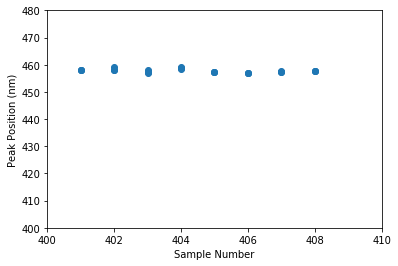

In [25]:
keys = []
peak_nm = []
for (key, uvs) in key2uv.items():
    for uv in uvs:
        keys.append(key)
        peak_nm.append(peak_fits[uv][0])
        
plt.scatter(keys, peak_nm)
plt.xlim(400,410)
plt.ylim(400,480)
plt.ylabel('Peak Position (nm)')
plt.xlabel('Sample Number')

Text(0.5, 0, 'Sample Number')

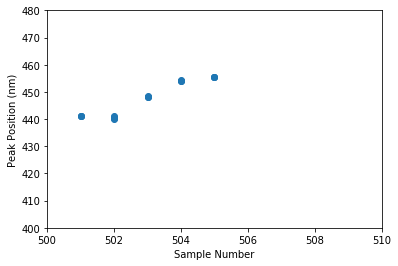

In [26]:
keys = []
peak_nm = []
for (key, uvs) in key2uv.items():
    for uv in uvs:
        keys.append(key)
        peak_nm.append(peak_fits[uv][0])
        
plt.scatter(keys, peak_nm)
plt.xlim(500,510)
plt.ylim(400,480)
plt.ylabel('Peak Position (nm)')
plt.xlabel('Sample Number')

Calibrating samples to actual concentrations based on the assigned calibration curves.

In [27]:
# volume concentrations will be used for SANS fitting but in our manuscript plots we always reference weight percent
# due to its common usage in the community, increasing ease of comparison between results in our work and others
def convert2volume(wtPs, rho_cp, rho_ps):
    # returns array of volume percents
    wtPs = np.array(wtPs)
    vol_cp = wtPs/rho_cp
    vol_ps = (wtPs*(-1)+100)/rho_ps
    volPs = vol_cp*100/(vol_cp+vol_ps)
    return volPs

In [28]:
samp_corrects = {} # key is sample key, value is (average corrected weight percent, standard deviation)
for key, uvs in key2uv.items():
    corrects = []
    for uv in uvs:
        if uv in cal_assign.keys():
            cal = cal_assign[uv]
        else: 
            cal = 0
        if cal in cal_fits.keys():
            peak_nm, peak_abs, peak_fit = peak_fits[uv]
            slope = cal_fits[cal]
            corrects.append(peak_abs/slope)
    if len(key2uv[key]) > 0:
        vol_percents = convert2volume(corrects, 1.1, 1.13) # cp density 1.1, PS-D8 density 1.13
        samp_corrects[key] = (
            np.average(corrects),
            np.std(corrects),
            np.average(vol_percents),
            np.std(vol_percents),
        )
        

### Plotting results of UV-Vis calibration

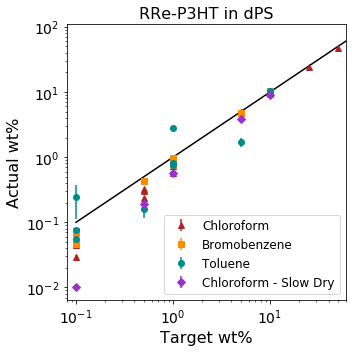

In [34]:
title = 'RRe-P3HT in dPS'
plt.figure(figsize=(5,5))

keys = [1,2,3,4,5,101,102,103,104,105,106,107,108,109,110,111,112]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='firebrick', fmt='^', label='Chloroform')

keys = [22,23,24,301,302,303,304,305,306,307,308]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='darkorange', fmt='s', label='Bromobenzene')

keys = [29,30,31,401,402,403,404,405,406,407,408]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='darkcyan', fmt='o', label='Toluene')

keys = [501,502,503,504,505]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='darkorchid', fmt='D', label='Chloroform - Slow Dry')


plt.legend(fontsize=12)

plt.plot([0.1, 70], [0.1, 70] , c='black')

plt.xscale('log')
plt.yscale('log')

plt.title(title, fontsize=16)
plt.ylabel('Actual wt%', fontsize=16)
plt.xlabel('Target wt%', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0.08, 60)

plt.tight_layout()

plt.savefig('../data/uv_vis/correction_figures/RReP3HT_Corrections.png', res=300)

plt.show()

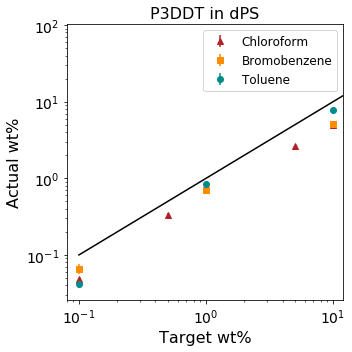

In [30]:
title = 'P3DDT in dPS'
plt.figure(figsize=(5,5))

keys = [11,12,13,14,15]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='firebrick', fmt='^', label='Chloroform')

keys = [25,26,27]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='darkorange', fmt='s', label='Bromobenzene')

keys = [32,33,34]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='darkcyan', fmt='o', label='Toluene')

plt.legend(fontsize=12)

plt.plot([0.1, 70], [0.1, 70] , c='black')

plt.xscale('log')
plt.yscale('log')

plt.title(title, fontsize=16)
plt.ylabel('Actual wt%', fontsize=16)
plt.xlabel('Target wt%', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0.08, 12)
plt.tight_layout()


plt.savefig('../data/uv_vis/correction_figures/P3DDT_Corrections.png', res=300)

plt.show()

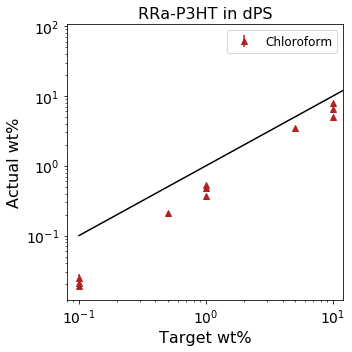

In [31]:
title = 'RRa-P3HT in dPS'
plt.figure(figsize=(5,5))

keys = [6,7,8,9,10,201,202,203,204,205,206]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='firebrick', fmt='^', label='Chloroform')


plt.legend(fontsize=12)

plt.plot([0.1, 70], [0.1, 70] , c='black')

plt.xscale('log')
plt.yscale('log')

plt.title(title, fontsize=16)
plt.ylabel('Actual wt%', fontsize=16)
plt.xlabel('Target wt%', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0.08, 12)
plt.tight_layout()


plt.savefig('../data/uv_vis/correction_figures/RRaP3HT_Corrections.png', res=300)

plt.show()

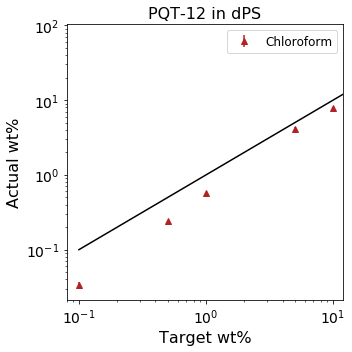

In [32]:
title = 'PQT-12 in dPS'
plt.figure(figsize=(5,5))

keys = [16,17,18,19,20]

theor = []
actual = []
std = []
for key in keys:
    theor.append(target[key]*100)
    actual.append(samp_corrects[key][0])
    std.append(samp_corrects[key][1])

plt.errorbar(theor, actual, yerr=np.array(std), color='firebrick', fmt='^', label='Chloroform')


plt.legend(fontsize=12)

plt.plot([0.1, 70], [0.1, 70] , c='black')

plt.xscale('log')
plt.yscale('log')

plt.title(title, fontsize=16)
plt.ylabel('Actual wt%', fontsize=16)
plt.xlabel('Target wt%', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0.08, 12)
plt.tight_layout()


plt.savefig('../data/uv_vis/correction_figures/PQT12_Corrections.png', res=300)

plt.show()

In [33]:
data = []
for key, value in samp_corrects.items():
    data.append(key)
    data.append(target[key]*100)
    data.append(value[0])
    data.append(value[1])
    data.append(value[2])
    data.append(value[3])
    

np.savetxt('../data/uv_vis/Corrected_wtPercents.csv', np.array(data).reshape(-1,6), delimiter=',', header='key, theoretical wt%, average actual wt%, st. dev. wt%, average actual vol%, st. dev. vol%', fmt=('%i','%s','%s','%s','%s','%s'))